In [1]:
#importing necessary libraries and frameworks
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random

#Check GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 1
Tensorflow GPU : True


DATA COLLECTION

In [2]:
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip

--2023-04-15 22:31:01--  https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.85.19, 13.249.85.39, 13.249.85.89, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.85.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19021600724 (18G) [application/zip]
Saving to: ‘CLEVR_v1.0.zip’

CLEVR_v1.0.zip      100%[===================>]  17.71G  57.2MB/s    in 5m 15s  

2023-04-15 22:36:16 (57.6 MB/s) - ‘CLEVR_v1.0.zip’ saved [19021600724/19021600724]



In [3]:
!unzip CLEVR_v1.0.zip

Streaming output truncated to the last 5000 lines.
  inflating: CLEVR_v1.0/images/train/CLEVR_train_041020.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_068755.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_008504.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057028.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057464.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_049590.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010322.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_038692.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_047594.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014228.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010552.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_030689.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_044484.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_026813.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014422.png  
  inflating: CLEVR_

DATA PRE-PROCESSING

In [12]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
lenghtData = 10000

trainList=[]
with open('/content/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for K in range(lenghtData):
        i = data['questions'][random.randrange(20, 5000, 3)]
        temp=[]
        for path in glob.glob('/content/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

In [12]:
valList=[]
lenghtData = int(0.3 * lenghtData)
with open('/content/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for k in range(lenghtData):
        i = data['questions'][random.randrange(20, 5000, 3)]
        temp=[]
        for path in glob.glob('/content/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

,Path,Question,Answer
0,/content/CLEVR_v1.0/images/val/CLEVR_val_00029...,There is a shiny thing in front of the tiny ru...,sphere
1,/content/CLEVR_v1.0/images/val/CLEVR_val_00034...,Are there any big red spheres that are on the ...,no
2,/content/CLEVR_v1.0/images/val/CLEVR_val_00030...,Are there any large metallic blocks that have ...,no
3,/content/CLEVR_v1.0/images/val/CLEVR_val_00021...,Is the material of the red cylinder that is in...,yes
4,/content/CLEVR_v1.0/images/val/CLEVR_val_00042...,There is a big thing that is in front of the s...,0


In [13]:
vocab_set=set()#set object used to store the vocabulary

tokenizer = tfds.deprecated.text.Tokenizer()

for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
#
#Creating an Encoder and a Function to preprocess the text data during the training and inference    
    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
index=14
print("Testing the Encoder with sample questions - \n ")
example_text=encoder.encode(train_dataframe['Question'][index])
print("Original Text = "+train_dataframe['Question'][index])
print("After Encoding = "+str(example_text))

Testing the Encoder with sample questions - 
 
Original Text = What is the size of the blue block that is the same material as the big purple thing?
After Encoding = [48, 19, 44, 2, 18, 44, 65, 81, 92, 19, 44, 62, 54, 94, 44, 25, 37, 88]


In [14]:
BATCH_SIZE=50
IMG_SIZE=(200,200)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

MODEL BUILDING

In [15]:
from tensorflow.keras.applications import VGG16, VGG19

MODEL - 1: MobileNetV2 + BiDirectional LSTM

In [16]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(200,200,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
                                                          weights='imagenet', input_tensor=CNN_Input)
#vgg = VGG16(weights="imagenet", include_top=False, input_shape = (224,224,3))
CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
#CNN_model.add(vgg)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
#RNN_model.add(tf.keras.layers.GRU(128,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 256)      25344       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 50, 512)     1050624     ['embedding_1[0][0]']      

In [17]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-1.csv", separator=',', append=False
)
teste =1

#create a checkpoint to save the training

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
epoch = 10

epoch = 10


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='weights.{epoch:02d}.ckpt', 
    verbose=1, 
    save_weights_only=True,
    save_freq=1000*BATCH_SIZE)



#def FormatarEndereco(epoch):
#    epoch = epoch+1
#    return "training_2/cp-"+ str(epoch) + ".ckpt"

#model.save_weights(FormatarEndereco(epoch))

model.save_weights(checkpoint_path.format(epoch=0,val_loss=0))
                   
with tf.device(device):
   history =  model.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS,cp_callback],
              epochs=10)

Epoch 1/10
200/200 [==============================] - 143s 457ms/step - loss: 1.4981 - sparse_categorical_accuracy: 0.5097 - val_loss: 5.0581 - val_sparse_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 86s 424ms/step - loss: 0.7865 - sparse_categorical_accuracy: 0.7238 - val_loss: 4.9294 - val_sparse_categorical_accuracy: 0.3044 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 86s 428ms/step - loss: 0.5037 - sparse_categorical_accuracy: 0.8099 - val_loss: 6.4172 - val_sparse_categorical_accuracy: 0.3489 - lr: 9.0484e-04
Epoch 4/10
200/200 [==============================] - 82s 408ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8475 - val_loss: 5.8889 - val_sparse_categorical_accuracy: 0.3589 - lr: 8.1873e-04
Epoch 5/10
200/200 [==============================] - 87s 435ms/step - loss: 0.3252 - sparse_categorical_accuracy: 0.8567 - val_loss: 6.3621 - val_sparse_categorical_accuracy: 0.3344 - lr: 7.4082e-04
Epoch 6

In [34]:
model.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS,cp_callback],
              epochs=2)

Epoch 1/2
164/200 [=======================>......] - ETA: 14s - loss: 0.5596 - sparse_categorical_accuracy: 0.7870

KeyboardInterrupt: ignored

Predictions Are as follows = 
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 4s 4s/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 35ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 42ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 34ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 37ms/step


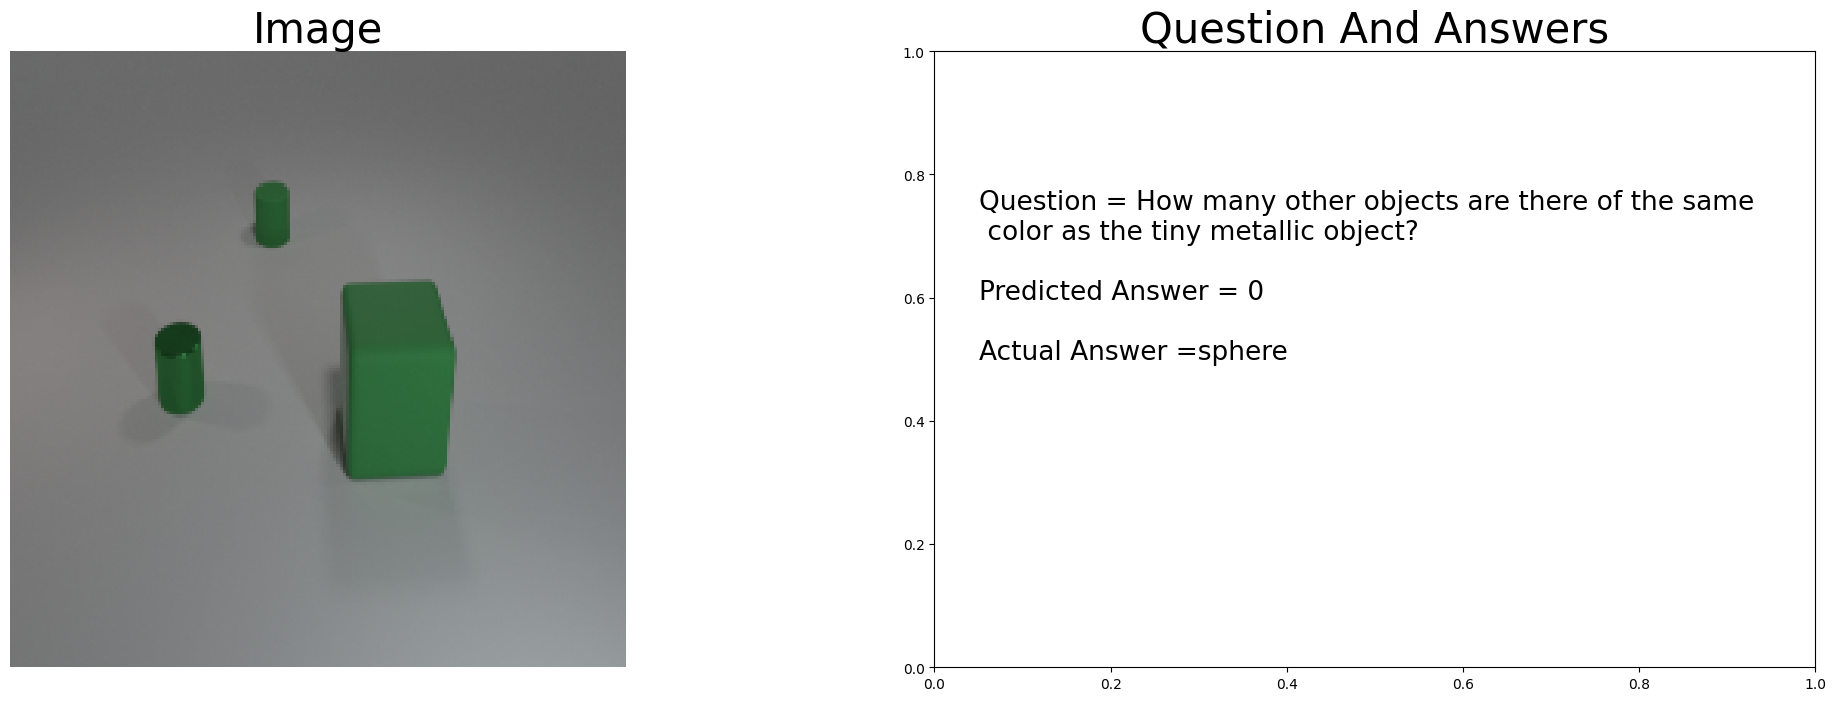

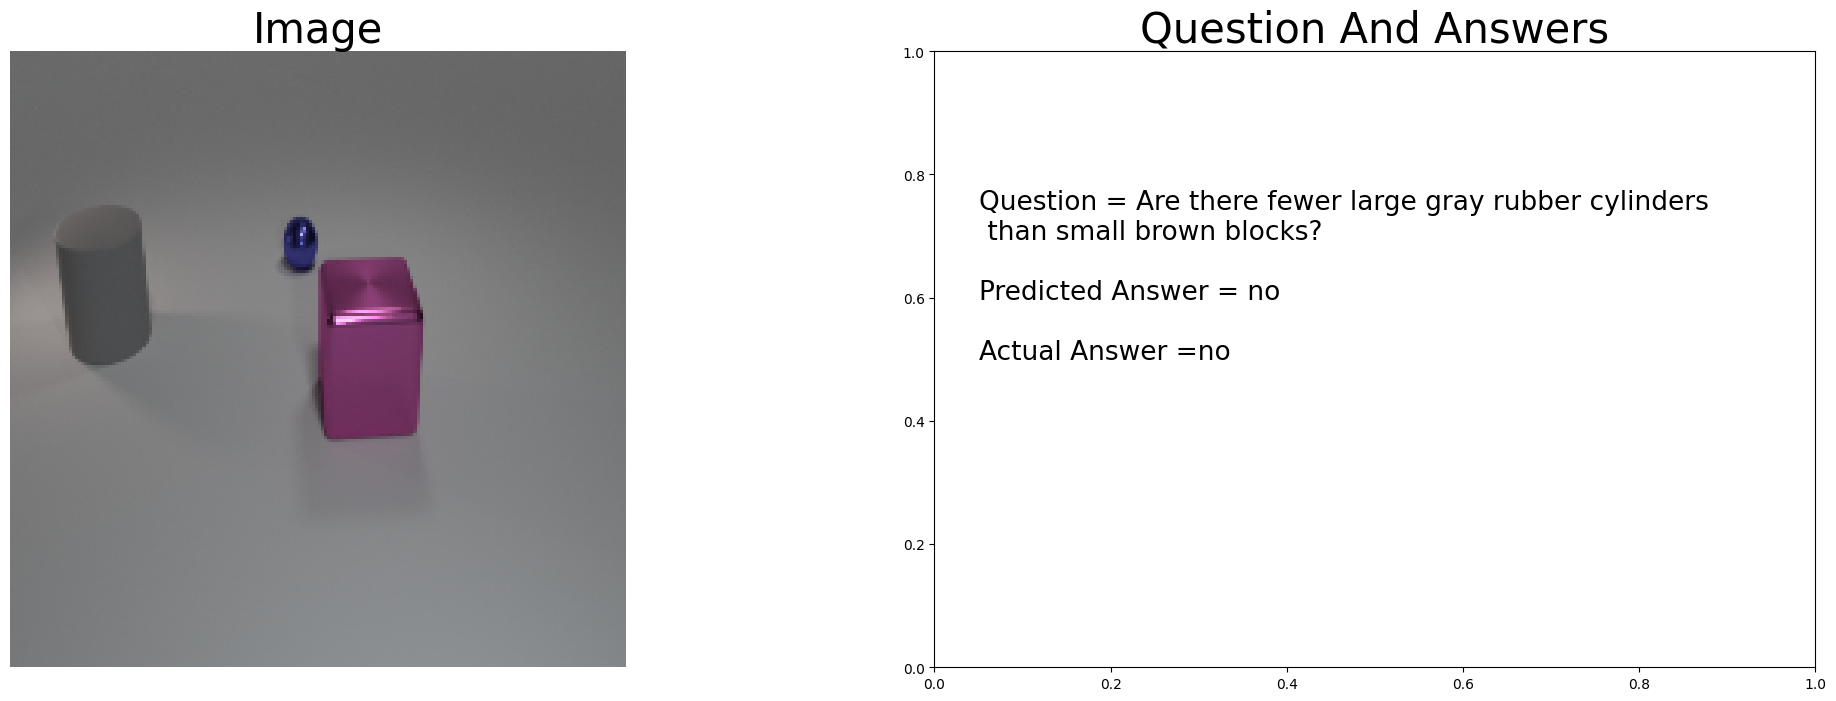

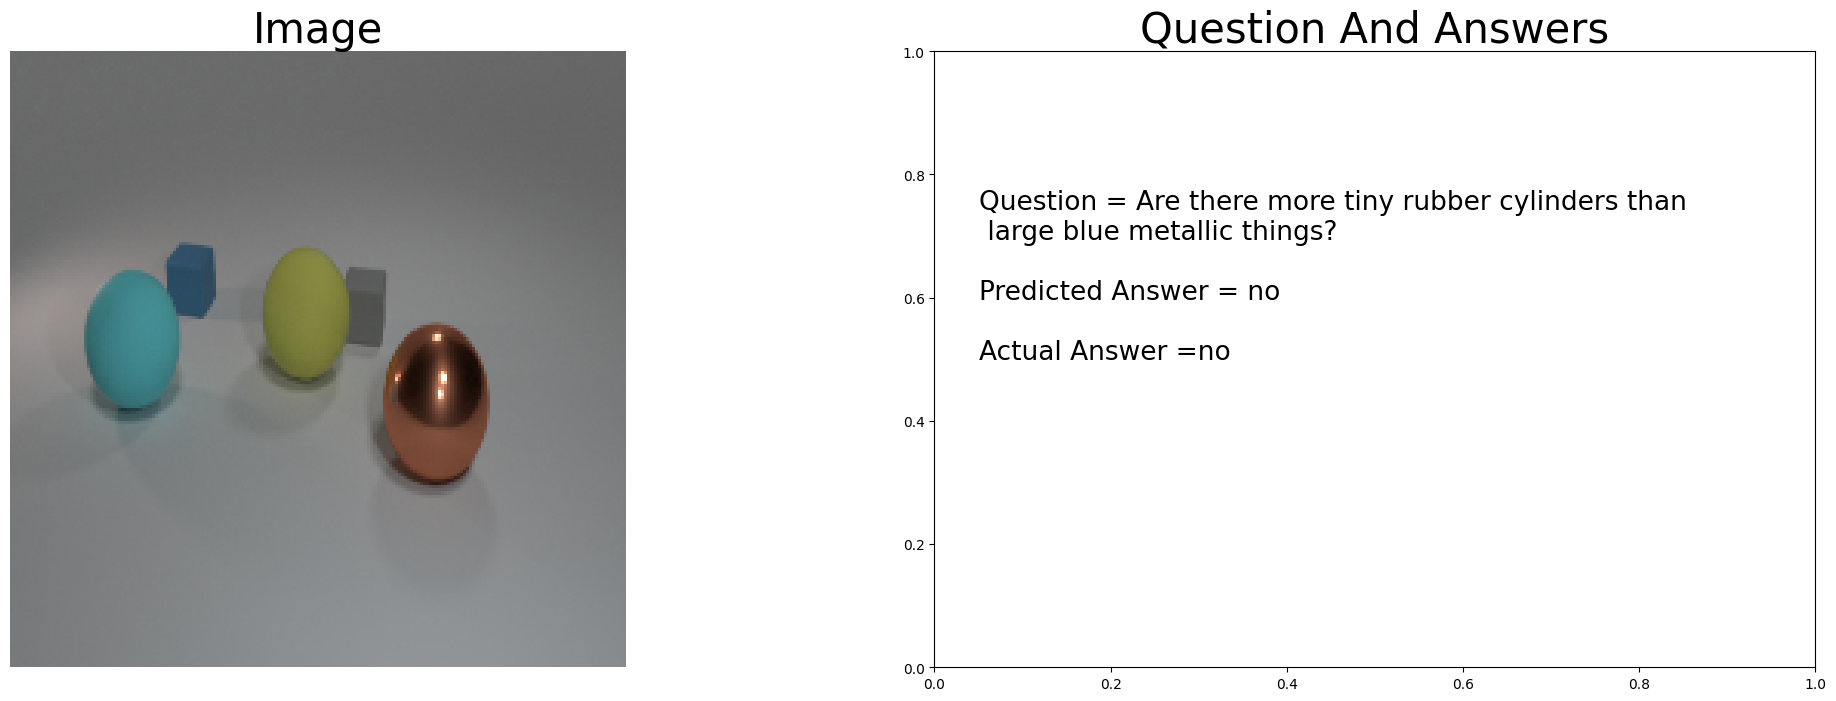

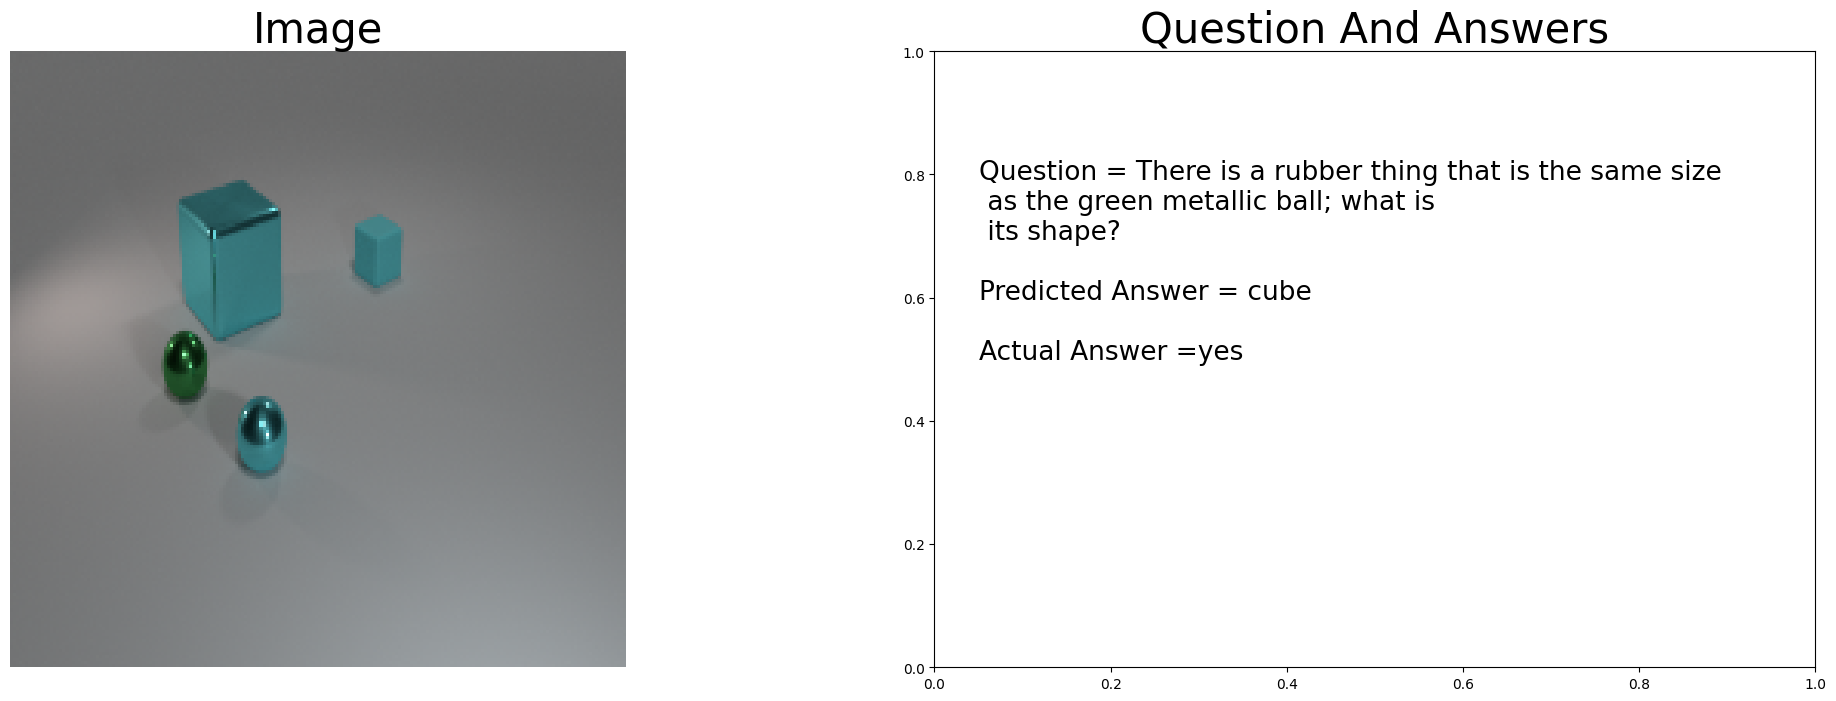

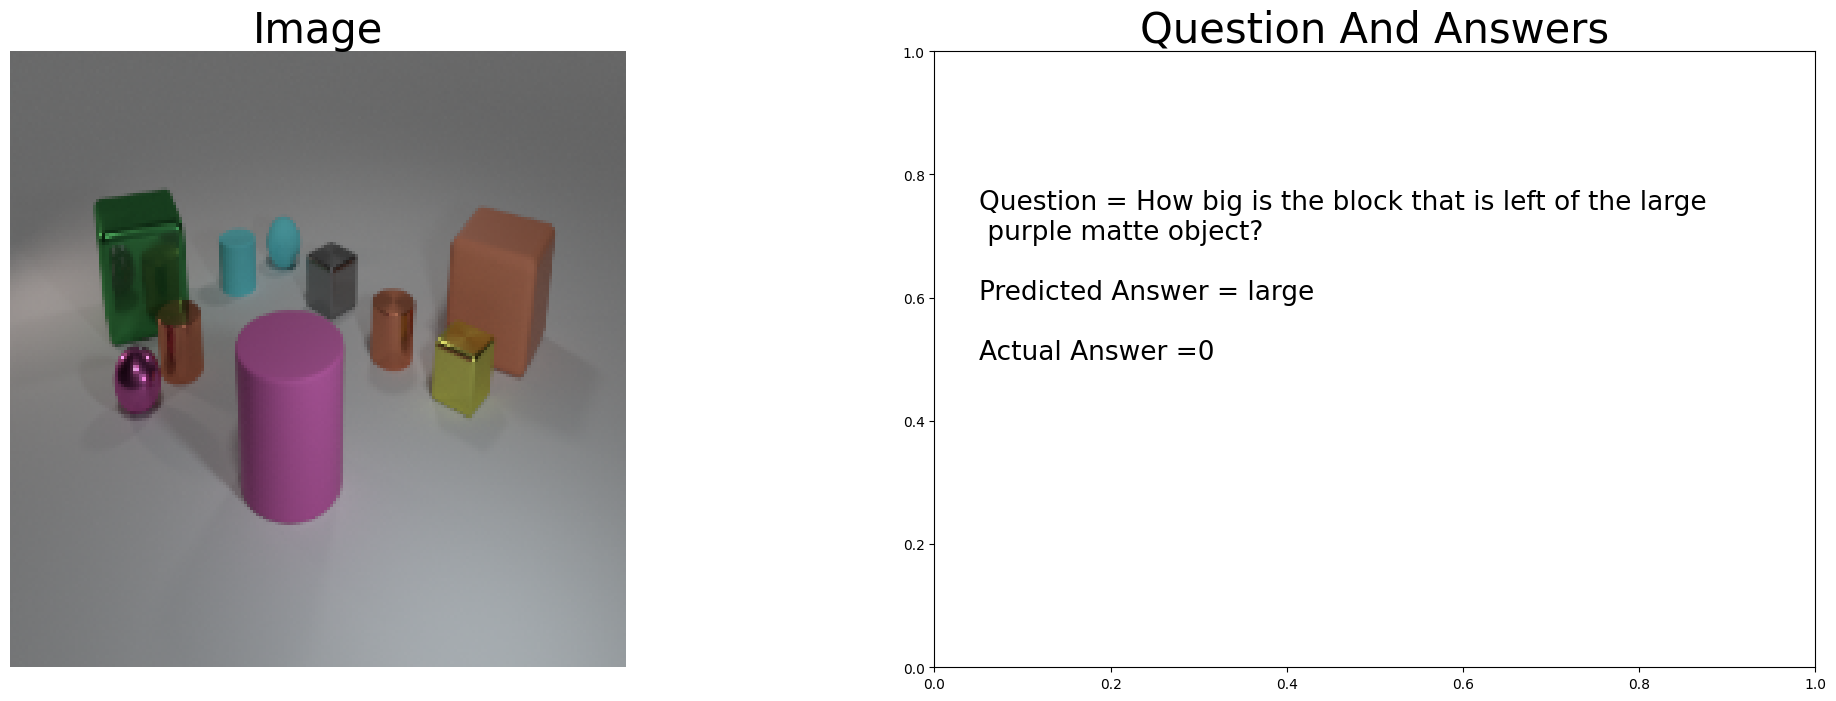

In [19]:
print("Predictions Are as follows = ")

for i in range(5):
    index=i
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(train_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(200,200))
    q=train_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(train_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [ ]:
print("Predictions Are as follows = ")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
history.history
hist.tail()

Predictions Are as follows = 


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr,epoch
0,1.972754,0.2925,1.483693,0.3769,0.001000,0
1,1.303166,0.3916,1.256900,0.4244,0.001000,1
2,1.054252,0.4356,1.132311,0.4227,0.000905,2
3,1.088164,0.4386,1.127893,0.4239,0.000819,3
4,1.006442,0.4585,1.109846,0.4212,0.000741,4


In [20]:
df = pd.read_csv("/content/Training Parameters-1.csv")
X = df['epoch']

font = {'size': 10}
plt.rc('font', **font)

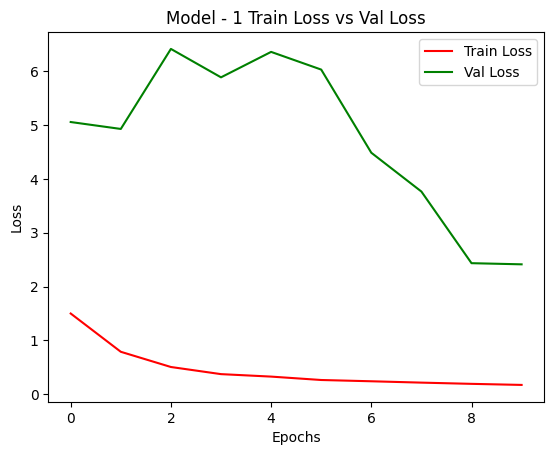

In [21]:
y = df['loss']
z = df['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 1 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

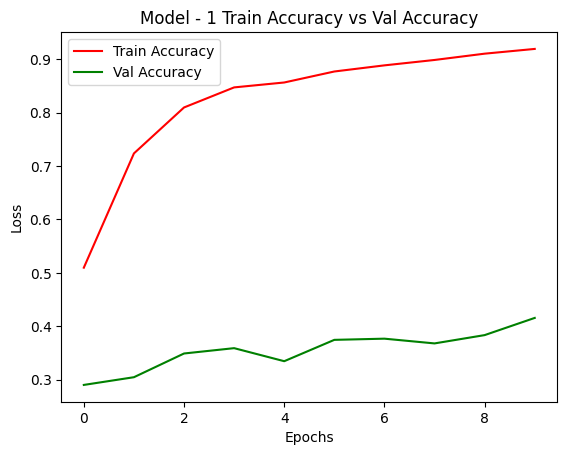

In [22]:
y = df['sparse_categorical_accuracy']
z = df['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 1 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

Model - 2: VGG-16 + Transformer

In [23]:
BATCH_SIZE=50
IMG_SIZE=(224,224)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def vgg16_encoder():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Bidirectional, LSTM


def transformer_encoder(input_shape, vocab_size, num_layers, embedding_dim, num_heads, 
                        feed_forward_dim, dropout_rate):
    inputs = Input(shape=input_shape,name='text_input')
    x = Embedding(vocab_size, embedding_dim)(inputs)
    
    for i in range(num_layers):
        # Multi-Head Attention
        multi_head_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + multi_head_output)
        
        # Feed-Forward
        ff_output = Dense(feed_forward_dim, activation='relu')(x)
        ff_output = Dropout(dropout_rate)(ff_output)
        ff_output = Dense(embedding_dim)(ff_output)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + ff_output)
        
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # LSTM Layer
    # x = Bidirectional(LSTM(embedding_dim))(x)
    
    #outputs = Dense(embedding_dim, activation='tanh')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model,inputs

In [ ]:
#RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model, RNN_Input = transformer_encoder(50, len(vocab_set), 5, 50, 3, 
                        256, 0.2)
RNN_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50, 50)       4900        ['text_input[0][0]']             
                                                                                                  
 multi_head_attention_10 (Multi  (None, 50, 50)      30500       ['embedding_3[0][0]',            
 HeadAttention)                                                   'embedding_3[0][0]']            
                                                                                                  
 tf.__operators__.add_20 (TFOpL  (None, 50, 50)      0           ['embedding_3[0][0]',      

In [ ]:
RNN_Input

<KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'text_input')>

In [26]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(224,224,3),name='image_input')

#mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
 #                                                          weights='imagenet', input_tensor=CNN_Input)
#vgg = VGG16(weights="imagenet", include_top=False, input_shape = (224,224,3))
vgg = vgg16_encoder()
CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
#CNN_model.add(mobilenetv2)
CNN_model.add(vgg)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
'''RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
RNN_model.add(tf.keras.layers.GRU(128,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))
'''
#RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model,RNN_Input = transformer_encoder(50, len(vocab_set), 5, 50, 3, 
                        256, 0.2)

concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model2 = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 50)       4900        ['text_input[0][0]']             
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 50)      30500       ['embedding_2[0][0]',            
 dAttention)                                                      'embedding_2[0][0]']            
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 50, 50)      0           ['embedding_2[0][0]',      

In [27]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-2.csv", separator=',', append=False
)
teste =1

#create a checkpoint to save the training

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
epoch = 10

epoch = 10


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='weights.{epoch:02d}.ckpt', 
    verbose=1, 
    save_weights_only=True,
    save_freq=1000*BATCH_SIZE)



#def FormatarEndereco(epoch):
#    epoch = epoch+1
#    return "training_2/cp-"+ str(epoch) + ".ckpt"

#model.save_weights(FormatarEndereco(epoch))

model2.save_weights(checkpoint_path.format(epoch=0,val_loss=0))
                   
with tf.device(device):
   history =  model2.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS,cp_callback],
              epochs=10)

Epoch 1/10
200/200 [==============================] - 184s 696ms/step - loss: 2.4149 - sparse_categorical_accuracy: 0.2461 - val_loss: 1.7619 - val_sparse_categorical_accuracy: 0.3322 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 139s 696ms/step - loss: 1.6128 - sparse_categorical_accuracy: 0.3368 - val_loss: 1.5892 - val_sparse_categorical_accuracy: 0.3422 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 138s 689ms/step - loss: 1.4533 - sparse_categorical_accuracy: 0.3598 - val_loss: 1.3815 - val_sparse_categorical_accuracy: 0.3533 - lr: 9.0484e-04
Epoch 4/10
200/200 [==============================] - 138s 689ms/step - loss: 1.2993 - sparse_categorical_accuracy: 0.3781 - val_loss: 1.3423 - val_sparse_categorical_accuracy: 0.3544 - lr: 8.1873e-04
Epoch 5/10
200/200 [==============================] - 138s 688ms/step - loss: 1.2711 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.3462 - val_sparse_categorical_accuracy: 0.3500 - lr: 7.4082e-04
Epo

In [35]:
model2.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS,cp_callback],
              epochs=1)

200/200 [==============================] - 139s 690ms/step - loss: 1.1676 - sparse_categorical_accuracy: 0.4300 - val_loss: 1.2540 - val_sparse_categorical_accuracy: 0.3689 - lr: 0.0010


Predictions Are as follows = 
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 1s 1s/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 32ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 32ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 42ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 34ms/step


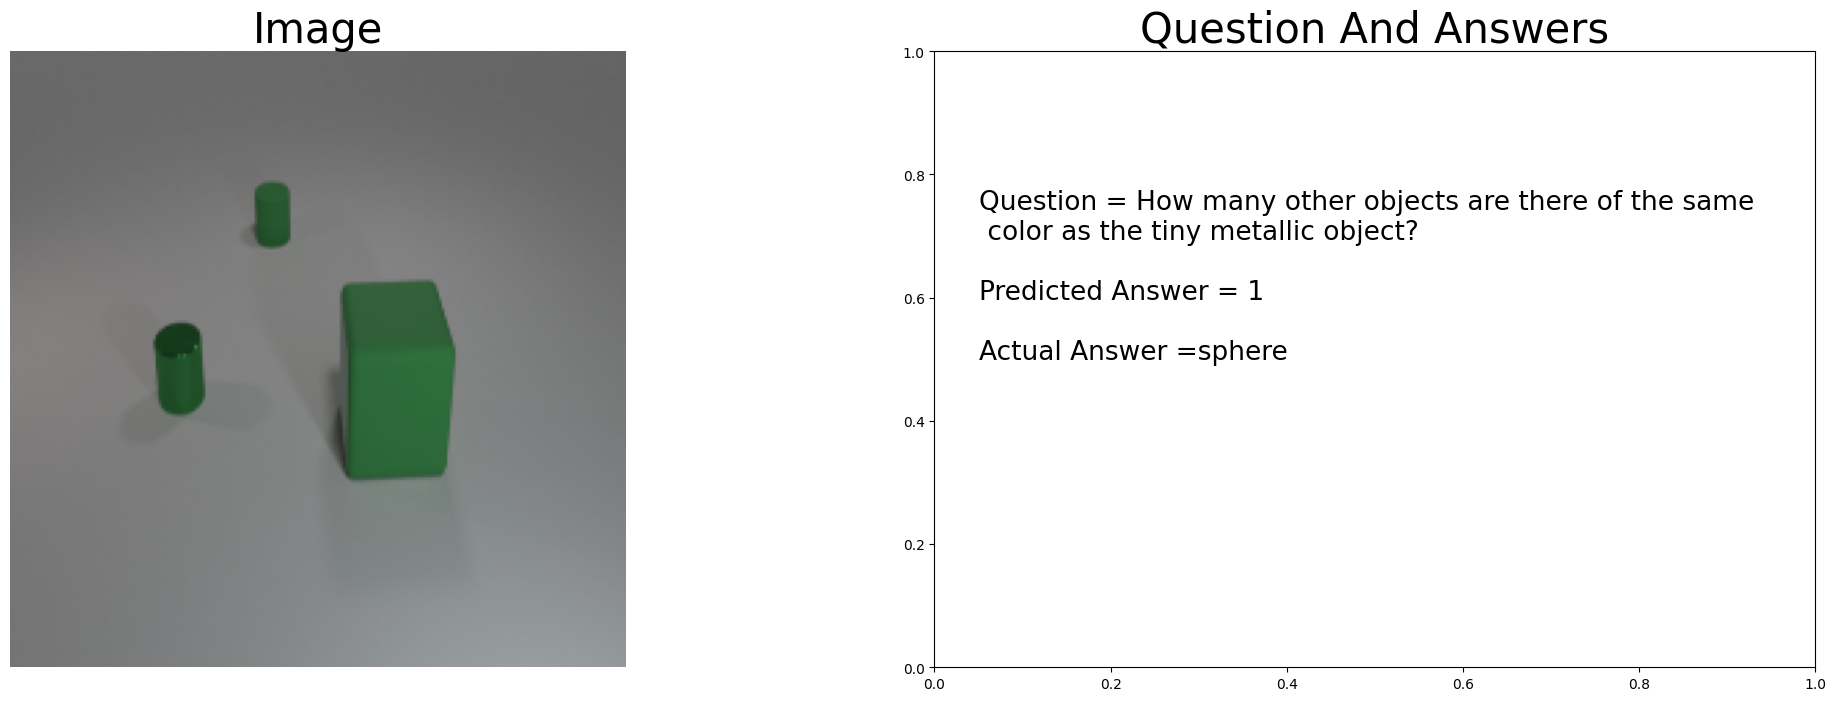

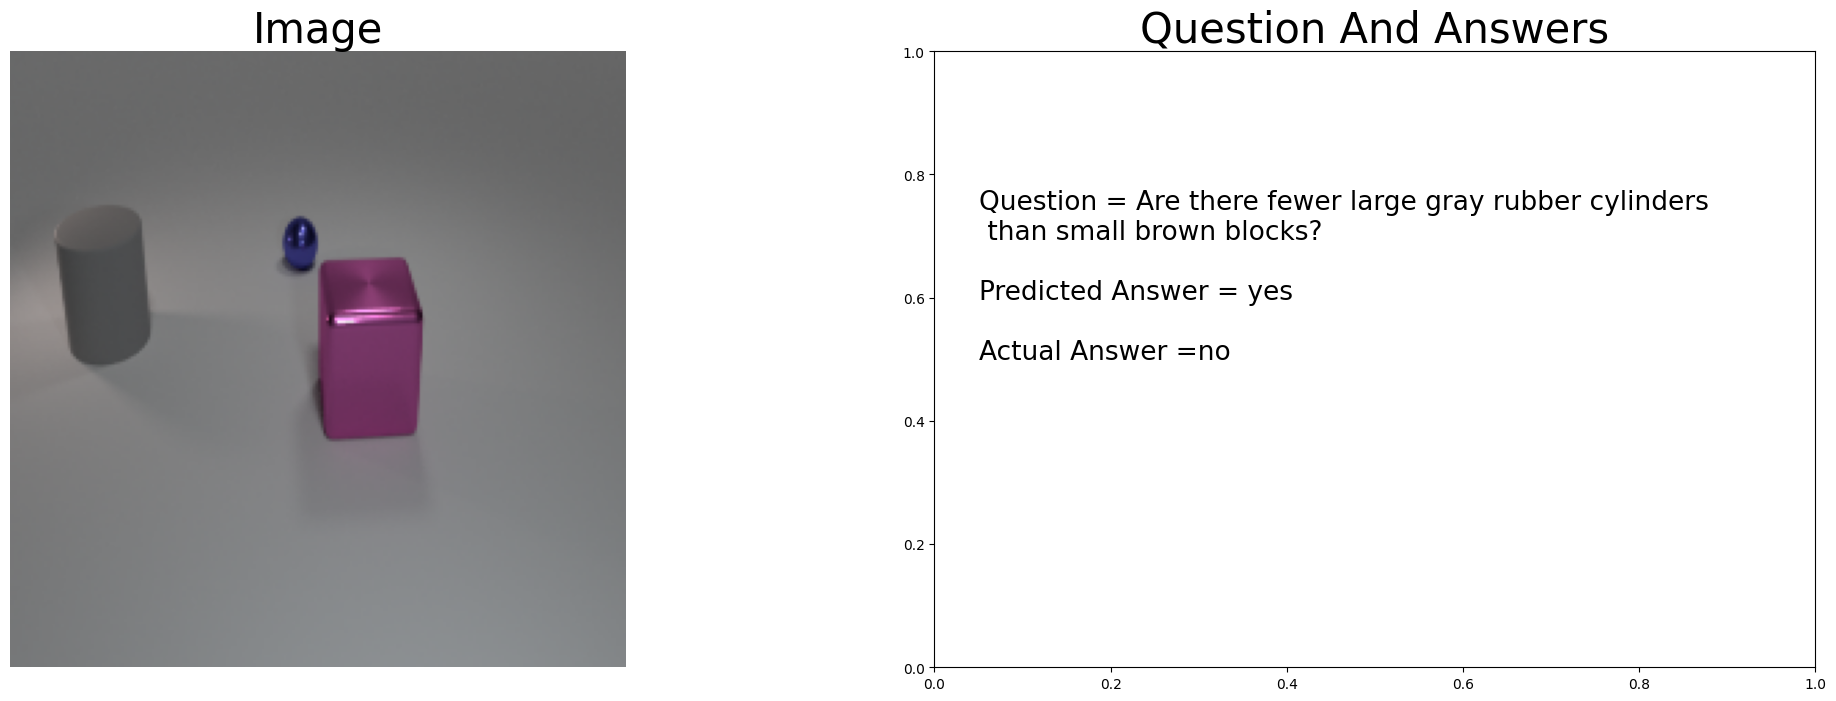

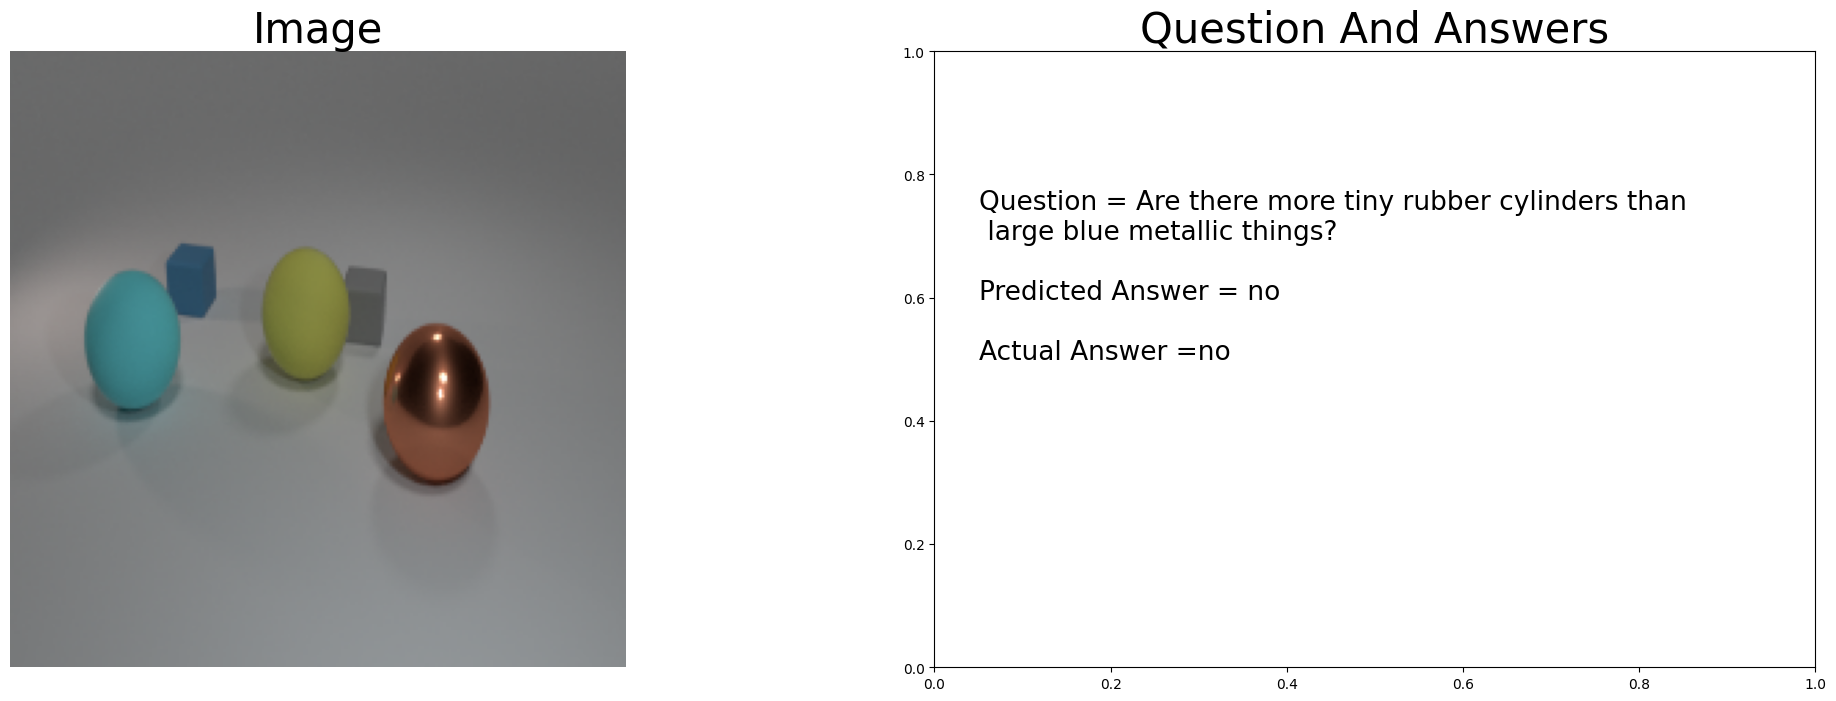

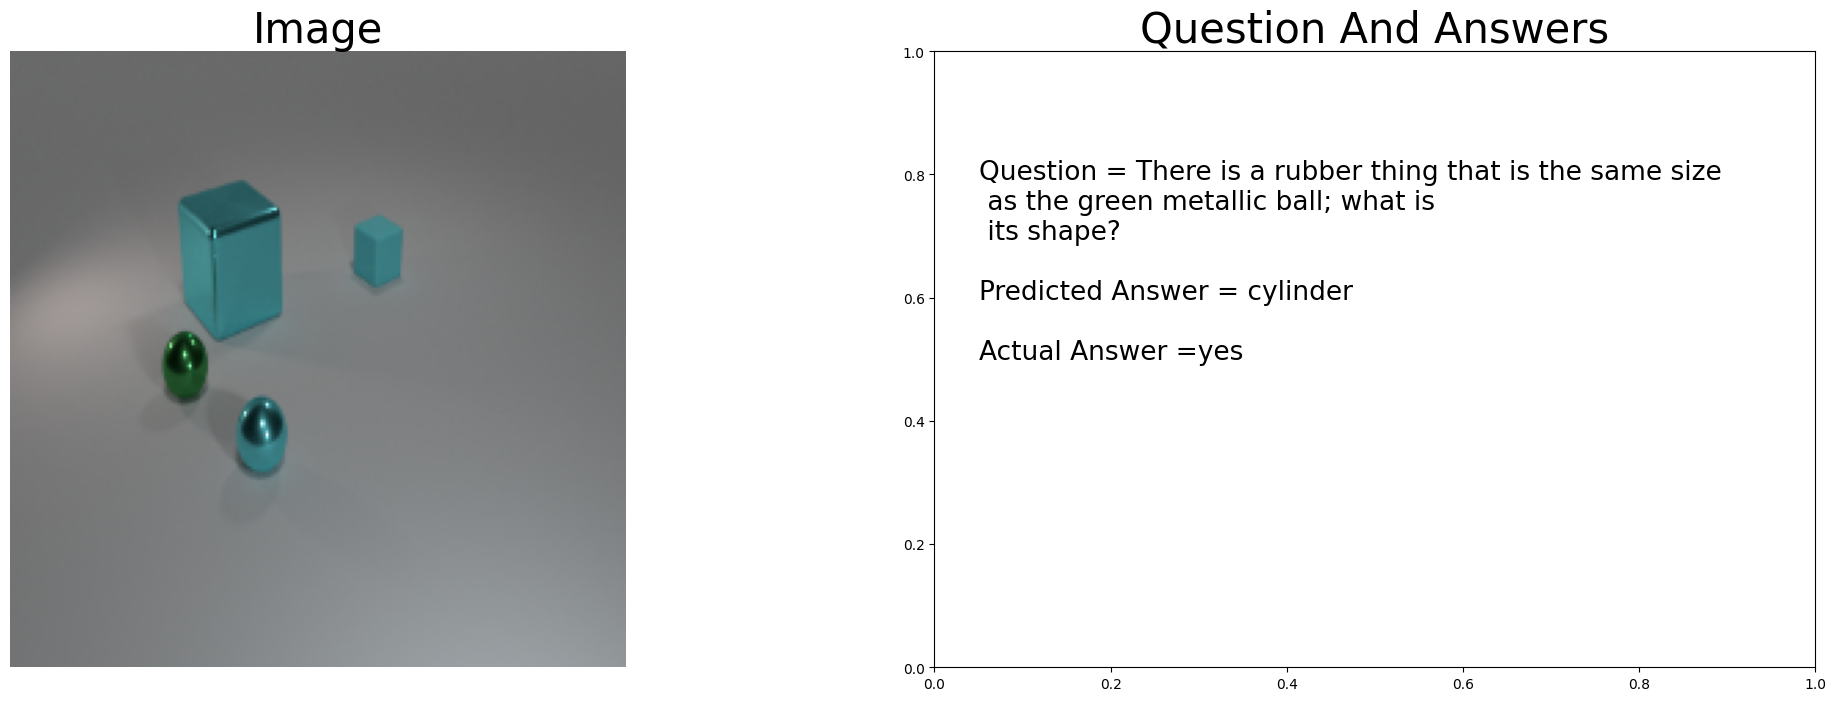

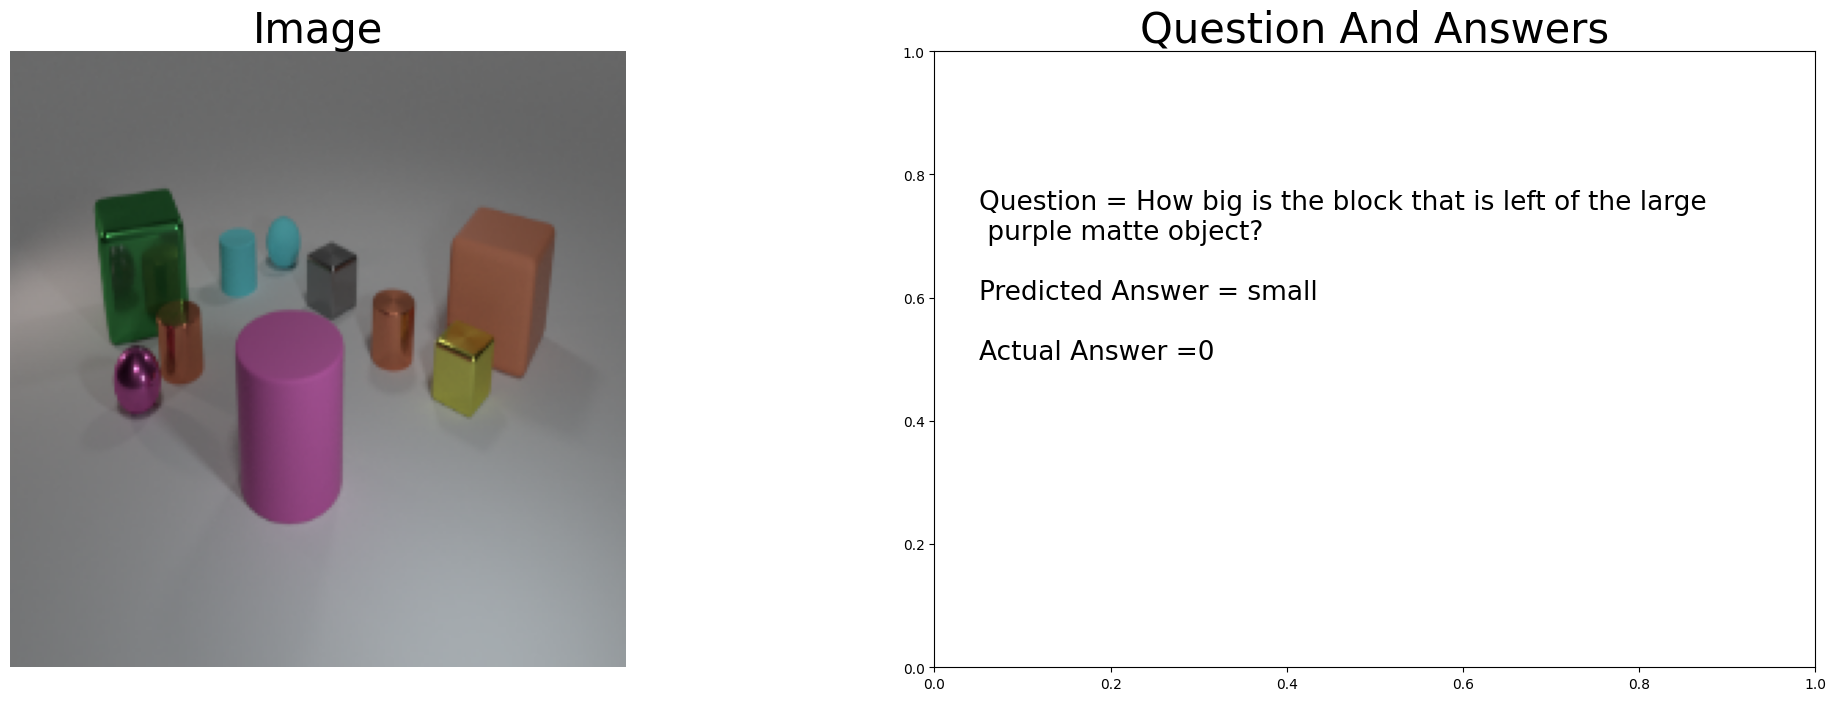

In [28]:
print("Predictions Are as follows = ")

for i in range(5):
    index=i
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(train_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(224,224))
    q=train_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model2.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(train_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [29]:
print("Predictions Are as follows = ")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
history.history
hist.tail()


Predictions Are as follows = 


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr,epoch
5,1.228291,0.4031,1.254598,0.372222,0.000670,5
6,1.160926,0.4245,1.254314,0.362222,0.000607,6
7,1.136941,0.4353,1.219540,0.358889,0.000549,7
8,1.109467,0.4403,1.232565,0.382222,0.000497,8
9,1.088648,0.4492,1.231409,0.392222,0.000449,9


In [30]:
df1 = pd.read_csv("/content/Training Parameters-2.csv")
X = df1['epoch']

font = {'size': 10}
plt.rc('font', **font)

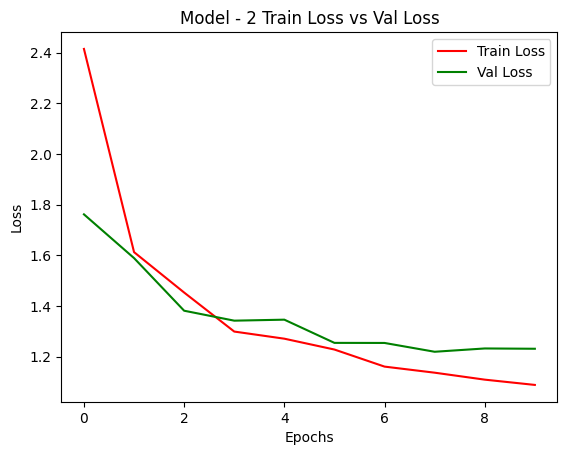

In [31]:
y = df1['loss']
z = df1['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 2 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

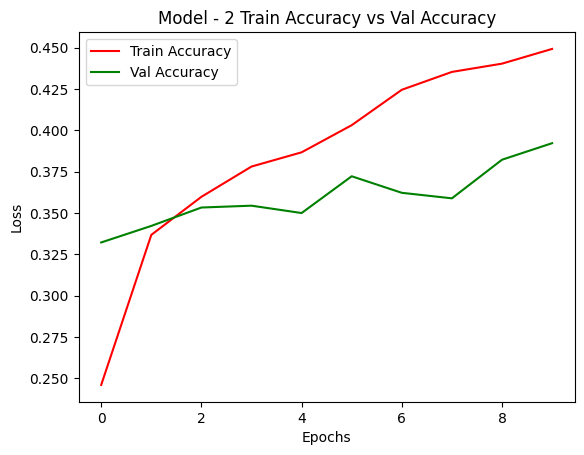

In [32]:
y = df1['sparse_categorical_accuracy']
z = df1['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 2 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Multiply,GlobalAveragePooling2D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, BatchNormalization


def vgg16_encoder(input_shape):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #outputs = Dense(256, activation='relu')(x)
    model = tf.keras.Model(inputs=vgg16.input, outputs=x)
    return model


def transformer_encoder(input_shape, vocab_size, num_layers, embedding_dim, num_heads, 
                        feed_forward_dim, dropout_rate):
    inputs = Input(shape=input_shape)
    x = Embedding(vocab_size, embedding_dim)(inputs)
    
    for i in range(num_layers):
        # Multi-Head Attention
        multi_head_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + multi_head_output)
        
        # Feed-Forward
        ff_output = Dense(feed_forward_dim, activation='relu')(x)
        ff_output = Dropout(dropout_rate)(ff_output)
        ff_output = Dense(embedding_dim)(ff_output)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + ff_output)
        
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    #outputs = Dense(embedding_dim, activation='tanh')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


def attention_model(image_shape, text_shape, vocab_size, num_layers, embedding_dim, 
                    num_heads, feed_forward_dim, dropout_rate):
    image_inputs = Input(shape=image_shape)
    text_inputs = Input(shape=text_shape)
    
    # VGG-16 Encoder
    image_encoder = vgg16_encoder(image_shape)
    image_encoder.trainable = False
    image_features = image_encoder(image_inputs)
    
    # Transformer Encoder
    text_encoder = transformer_encoder(text_shape, vocab_size, num_layers, embedding_dim, num_heads, 
                                        feed_forward_dim, dropout_rate)
    text_features = text_encoder(text_inputs)
    
    # Attention
    attn_scores = tf.matmul(text_features, image_features, transpose_b=True)
    attn_weights = tf.nn.softmax(attn_scores, axis=1)
    text_context = tf.matmul(attn_weights, image_features)
    image_context = tf.keras.layers.Reshape((1, 256))(image_features)
    features = Concatenate(axis=1)([text_context, image_context])
    features = BatchNormalization()(features)
    
    # Classifier
    features = Flatten()(features)
    features = Dense(128, activation='relu')(features)
    features = Dropout(0.5)(features)
    outputs = Dense(num_classes, activation='softmax')(features)
    
    model = tf.keras.Model(inputs=[image_inputs, text_inputs], outputs=outputs)
    return model


In [ ]:
model = attention_model((200,200,3), 50, len(vocab_set), 3, 50, 
                    3, 256, 0.2)
model.summary()

ValueError: ignored